# Predicting the size of the company you will join after graduation.


<div style="border-width:1; border-radius: 15px; border-style: solid; border-color: rgb(10, 10, 10); background-color: #316B83; text-align: center;font: 14pt 'Candara';font-weight:bold;"><h1> Stating the QS</h1></div>


> #### _`QS:`_ Can we predict the size of the company you will join after graduation?
>
> | Set Expectation                                               | Collect Info | Match Results |
> | ------------------------------------------------------------- | ------------ | ------------- |
> | Question is answerable, there exist enough data to answer it. | -            | -             |
>
> <br>


## Imports


In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# use random forest to predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [140]:
sns.set_style(
    style='darkgrid',
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')


<div style="border-width:1; border-radius: 15px; border-style: solid; border-color: rgb(10, 10, 10); background-color: #316B83; text-align: center;font: 14pt 'Candara';font-weight:bold;"><h1> Data Exploration</h1></div>


## Read the Data


### licenses & certifications


In [141]:
students_licenses = pd.read_csv('../data/preprocessed-data/csv/licenses.csv')

# drop na in Title column
students_licenses.dropna(subset=['Title'], inplace=True)

students_licenses.head()


,Title,Issuer,Date,User
0,Algorithms Analysis and Data Structures,Pluralsight,Issued Oct 2022,%D9%90%D9%90amiraelmergawy
1,Designing RESTful Web APIs,Pluralsight,Issued Sep 2022,%D9%90%D9%90amiraelmergawy
2,Programming Using C,Sololearn,Issued Aug 2022,%D9%90%D9%90amiraelmergawy
3,Advanced Express,LinkedIn,Issued Mar 2022,-ezz
4,Advanced Node.js,LinkedIn,Issued Mar 2022,-ezz


### education


In [142]:
students_education = pd.read_csv(
    '../data/preprocessed-data/normalized csv/educations.csv')

students_education.dropna(subset=['university_name'], inplace=True)

# remove #iti from university_name
students_education = students_education[students_education['university_name'] != '#iti']

# get students whose university is in the top 10
top_10_universities = students_education['university_name'].value_counts().head(
    15).index

print(top_10_universities)

students_education = students_education[students_education['university_name'].isin(
    top_10_universities)]

print(len(students_education))
students_education.head()


Index(['cairo', 'ain shams', 'alexandria', 'mansoura', 'institute', 'guc',
       'zagazig', 'tanta', 'benha', 'helwan', 'modern academy', 'bue',
       'suez canal', 'minufiya', 'zewail city'],
      dtype='object')
737


,University,Degree,Date,User,university_name,faculty_name
1,ain shams university,"bachelor's degree, computer science",2016 - 2020,%D9%90%D9%90amiraelmergawy,ain shams,computer
7,ain shams university,"bachelor of engineering (b.eng.), computers an...",2013 - 2018,a-mohsen,ain shams,computer
10,cairo university,"bachelor's degree, communications and computer...",2014 - 2019,a-youssry,cairo,computer
11,cairo university,"bachelor of engineering - be, computer enginee...",2017 - 2022,aaarafat,cairo,computer
13,cairo university,"good, electronic and communication",2002 - 2007,aabdelsattaar,cairo,electronic


### companies


In [143]:
companies = pd.read_csv('../data/companies/companies.csv')

# remove na companySize
companies.dropna(subset=['companySize'], inplace=True)

# select only companySize column
companies = companies[['companySize', 'name', 'query']]
print(companies['companySize'].value_counts())
companies.head()


11-50 employees           336
51-200 employees          220
2-10 employees            123
201-500 employees         114
1,001-5,000 employees      86
10,001+ employees          86
501-1,000 employees        56
5,001-10,000 employees     35
0-1 employees               7
Name: companySize, dtype: int64


,companySize,name,query
0,51-200 employees,National Telecommunication Institute (NTI),https://www.linkedin.com/company/15805726/
2,11-50 employees,(ISCC) International Staffing & Consulting Co.,https://www.linkedin.com/company/2205041/
3,11-50 employees,sonono,https://www.linkedin.com/company/30101254/
4,"1,001-5,000 employees",Etisalat Egypt,https://www.linkedin.com/company/777868/
5,11-50 employees,"The Translation Gate, LLC",https://www.linkedin.com/company/2229028/


### experiences


In [144]:
students_experiences = pd.read_csv(
    '../data/preprocessed-data/normalized csv/experiences.csv', converters={'From': pd.to_datetime})
students_experiences[students_experiences['User'] == '-ezz']


,User,CompanyUrl,Company,Title,EmploymentType,From,To,Duration,Location,title_tag
4,-ezz,https://www.linkedin.com/company/30101254/,sonono,software engineer,Full-time,2022-01-01,Present,16.0,"Basel, Switzerland",Software
5,-ezz,https://www.linkedin.com/company/294614/,Information Technology Institute (ITI),internship trainee,Full-time,2021-10-01,Jan 2022,4.0,Egypt,Internship
6,-ezz,UNKNOWN,CEL - Consulting Engineering Bureau,senior geotechnical engineer,Full-time,2019-09-01,Aug 2020,12.0,Egypt,NaN


In [145]:
# sort by From date
students_experiences.sort_values(by='From', inplace=True)

# keep only the first experience for each student
students_experiences.drop_duplicates(
    subset=['User'], keep='first', inplace=True)

print(len(students_experiences))
students_experiences.head()


835


,User,CompanyUrl,Company,Title,EmploymentType,From,To,Duration,Location,title_tag
1451,ibrahim-sobh-phd-8681757,https://www.linkedin.com/company/6659/,Orascom Telecom,intern,NaN,1996-06-01,Aug 1996,3.0,NaN,Internship
3215,tarekdawoud,UNKNOWN,ICCC,"software developer, lead software developer",NaN,1998-01-01,2000,24.0,NaN,Lead
1768,mahmoud-mohasseb-9b8b514,UNKNOWN,POET egypt,application programmer,NaN,2003-12-01,Dec 2004,13.0,"EGYPT, Alexandria",NaN
2482,mona-shafiq-pmp-itil-68b435b3,UNKNOWN,Bright Worx,web development trainee,NaN,2006-07-01,Sep 2006,3.0,Maadi,Fullstack
704,amr-el-agamy-45a72a2,https://www.linkedin.com/company/2697/,Mentor Graphics,software development engineer,NaN,2006-08-01,Jul 2012,72.0,NaN,Software


In [146]:
# join experiences with companies
students_experiences = students_experiences.merge(
    companies, left_on='Company', right_on='name', how='left')

# join experiences with education
students_experiences = students_experiences.merge(
    students_education, left_on='User', right_on='User', how='left')

# add a field for taking an intternship

students_experiences.head()


,User,CompanyUrl,Company,Title,EmploymentType,From,To,Duration,Location,title_tag,companySize,name,query,University,Degree,Date,university_name,faculty_name
0,ibrahim-sobh-phd-8681757,https://www.linkedin.com/company/6659/,Orascom Telecom,intern,NaN,1996-06-01,Aug 1996,3.0,NaN,Internship,"10,001+ employees",Orascom Telecom,https://www.linkedin.com/company/6659/,cairo university,"phd -, machine learning, deep learning, reinfo...",2011 - 2017,cairo,NaN
1,ibrahim-sobh-phd-8681757,https://www.linkedin.com/company/6659/,Orascom Telecom,intern,NaN,1996-06-01,Aug 1996,3.0,NaN,Internship,"10,001+ employees",Orascom Telecom,https://www.linkedin.com/company/6659/,cairo university,"m.sc, machine learning, automatic document sum...",2005 - 2009,cairo,NaN
2,ibrahim-sobh-phd-8681757,https://www.linkedin.com/company/6659/,Orascom Telecom,intern,NaN,1996-06-01,Aug 1996,3.0,NaN,Internship,"10,001+ employees",Orascom Telecom,https://www.linkedin.com/company/6659/,cairo university,"b.sc, computer engineering",1992 - 1997,cairo,computer
3,tarekdawoud,UNKNOWN,ICCC,"software developer, lead software developer",NaN,1998-01-01,2000,24.0,NaN,Lead,NaN,NaN,NaN,cairo university,"bachelor of science (b.sc.), computer engineering",1992 - 1997,cairo,computer
4,mahmoud-mohasseb-9b8b514,UNKNOWN,POET egypt,application programmer,NaN,2003-12-01,Dec 2004,13.0,"EGYPT, Alexandria",NaN,NaN,NaN,NaN,alexandria university,"b.sc., computer science",1997 - 2002,alexandria,computer


> #### _`QS:`_ Can we predict the size of the company you will join after graduation?
>
> | Set Expectation                                               | Collect Info                                                                                       | Match Results                                                                                                                                                                                                                                                                                  |
> | ------------------------------------------------------------- | -------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
> | Question is answerable, there exist enough data to answer it. | We don't have enough data i.e. features to predict the company size you will join after graduation | ❌ Our initial expectation does not align with the data we have collected. The company size you will join will absolutely depend on your current university, current faculty, courses you took, internships you got, your preferences, and a lot of other factors that we didn't manage to get |
>
> <br>

> #### _`New QS:`_ Can we predict the size of the company you will join after graduation based on your current university and faculty?
>
> | Set Expectation                                                                        | Collect Info | Match Results |
> | -------------------------------------------------------------------------------------- | ------------ | ------------- |
> | Question is answerable, there exist enough data to answer it.                          | -            | -             |
>
> <br>


## Relation between the size of the company and the university


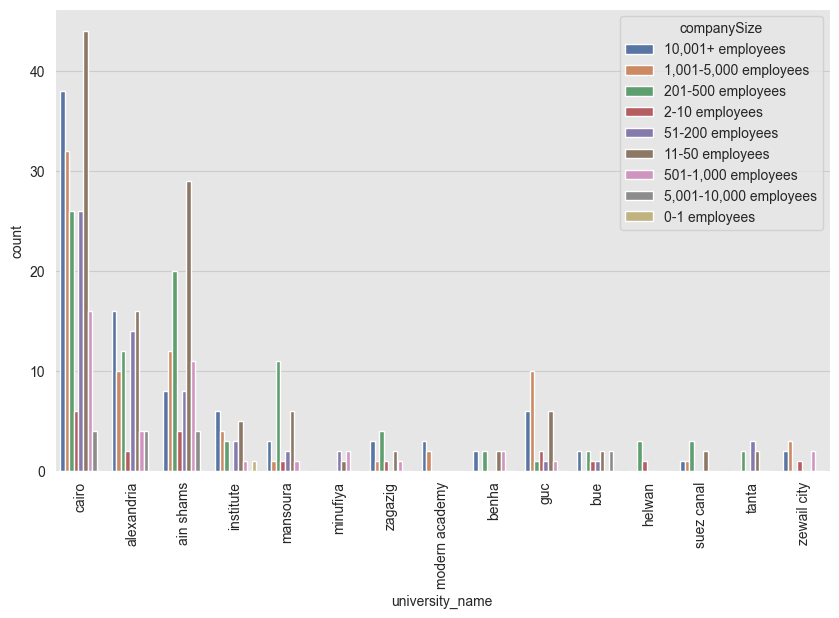

In [147]:
# plot university_name against companySize
plt.figure(figsize=(10, 6))
sns.countplot(x='university_name', hue='companySize',
              data=students_experiences)
plt.xticks(rotation=90)
plt.show()




## Relation between the size of the company and the faculty


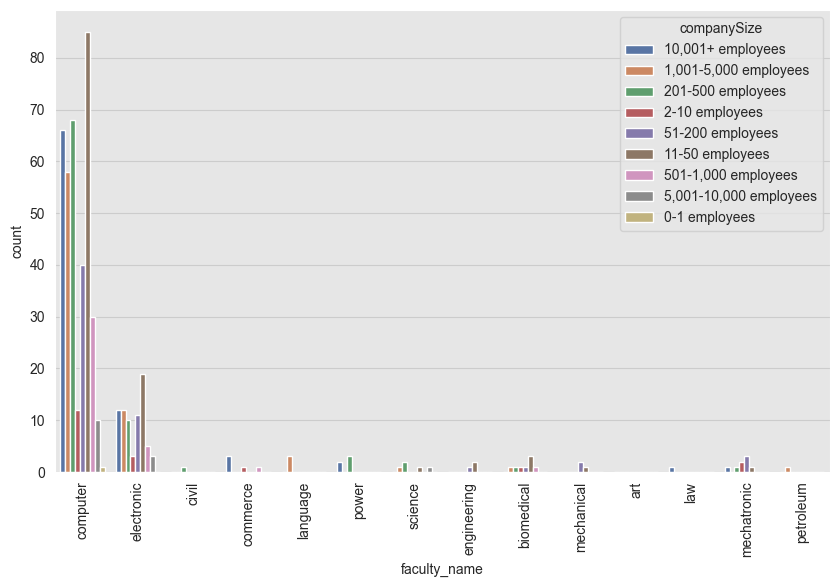

In [148]:
# plot university_name against companySize
plt.figure(figsize=(10, 6))
sns.countplot(x='faculty_name', hue='companySize',
              data=students_experiences)
plt.xticks(rotation=90)
plt.show()

## Data Preparation


In [149]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate


NUM_FOLDS = 5
TEST_RATIO = 0.2

df = students_experiences[['university_name', 'faculty_name', 'companySize']]

# drop na
df = df.dropna()

# encode university_name
df = pd.get_dummies(df, columns=['university_name', 'faculty_name'])

# encode companySize
le = LabelEncoder()
df['companySize'] = le.fit_transform(df['companySize'])

X = df.drop(columns=['companySize'])
y = df['companySize']

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO)

print(f"we have {len(X)} records, {len(X_train)} are used for training and {len(X_test)} are used for testing")


we have 488 records, 390 are used for training and 98 are used for testing


## Some utilities


In [150]:
from sklearn.model_selection import learning_curve
from mlxtend.evaluate import bias_variance_decomp  # pip install mlxtend


def getLearningCurvePlot(estimator, X, y, cv=5, scoring='f1_weighted', modelname='model'):
    # It uses cross-validation with cv folds
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv,
                                                            train_sizes=np.linspace(
                                                                .1, 1.0, 5),
                                                            scoring='f1_weighted', shuffle=True, random_state=42)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title(f'Learning Curves for {modelname}')
    plt.xlabel('Training Set Size')
    plt.ylabel(f'1 - {scoring}')
    plt.ylim(0.0, 1.1)
    plt.grid()

    plt.fill_between(train_sizes, 1-(train_scores_mean - train_scores_std),
                     1-(train_scores_mean + train_scores_std), alpha=0.1, color='r')
    plt.fill_between(train_sizes, 1-(test_scores_mean - test_scores_std),
                     1-(test_scores_mean + test_scores_std), alpha=0.1, color='g')

    plt.plot(train_sizes, 1-train_scores_mean, 'o-', color='r', label='Ein')
    plt.plot(train_sizes, 1-test_scores_mean, 'o-', color='g', label='Eval')

    plt.legend(loc='best')
    return plt


def getBiasVariance(estimator, X_train, y_train, X_test, y_test):
    # convert X, y, X_test, y_test to numpy arrays
    XX = X_train.to_numpy()
    yy = y_train.to_numpy()
    XX_test = X_test.to_numpy()
    yy_test = y_test.to_numpy()

    # perform the bias-variance analysis
    mse, bias, var = bias_variance_decomp(
        estimator, X_train=XX, y_train=yy, X_test=XX_test, y_test=yy_test, loss='mse', random_seed=42)
    return mse, bias, var


> #### _`QS:`_ Can we predict the size of the company you will join after graduation based on your current university and faculty?
>
> | Set Expectation                                                                        | Collect Info | Match Results |
> | -------------------------------------------------------------------------------------- | ------------ | ------------- |
> | Question is answerable, there exist enough data to answer it.                          | Yes, we have enough data to check if there is a relation or not  |  _`Matches`_  |
>
> <br>

<div style="border-width:1; border-radius: 15px; border-style: solid; border-color: rgb(10, 10, 10); background-color: #316B83; text-align: center;font: 14pt 'Candara';font-weight:bold;"><h1> Build Models</h1></div>


### Dummy Model

The DummyClassifier class in scikit-learn provides several strategies for a baseline method, such as predicting the most frequent class label, predicting a random class label, or predicting based on the class distribution of the training set.

**Strategy to use to generate predictions:**

1. "most_frequent":
   - The predict method always returns the most frequent class label in the observed y argument passed to fit.
   - The predict_proba method returns the matching one-hot encoded vector.
2. "prior":

- The predict method always returns the most frequent class label in the observed y argument passed to fit (like "most_frequent").
- Predict_proba always returns the empirical class distribution of y also known as the empirical class prior distribution.

3. "stratified":

- The predict_proba method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities.
- The predict method returns the class label which got probability one in the one-hot vector of predict_proba. Each sampled row of both methods is therefore independent and identically distributed.

4. "uniform":

- Generates predictions uniformly at random from the list of unique classes observed in y, i.e. each class has equal probability.

5. "constant":

- Always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class.


In [151]:
from sklearn.dummy import DummyClassifier

# Train ZeroR on the training set
zeroR = DummyClassifier(strategy='stratified')
zeroR.fit(X, y)

# cross validation
# -------------

cv_results = cross_validate(zeroR, X, y, cv=NUM_FOLDS, scoring=[
                            'f1_macro', 'accuracy', 'f1_micro'])

print(f'Results for cross validation with {NUM_FOLDS} folds:')
print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())


print('-' * 50)
# test and train
# -------------

# fit the model
zeroR.fit(X_train, y_train)

# predict
y_pred = zeroR.predict(X_test)

# evaluate
acc = accuracy_score(y_test, y_pred)

print(f'Results for train and test with {TEST_RATIO} as a test ratio')

print('accuracy: ', acc)


Results for cross validation with 5 folds:
accuracy:  0.16391752577319588
f1_macro:  0.11045940671695184
f1_micro:  0.16391752577319588
--------------------------------------------------
Results for train and test with 0.2 as a test ratio
accuracy:  0.19387755102040816


/home/mostafa/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


### RandomForestClassifier


/home/mostafa/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Results for cross validation with 5 folds:
accuracy:  0.21510624868504102
f1_macro:  0.06793486979041843
f1_micro:  0.21510624868504102
--------------------------------------------------
Results for train and test with 0.2 as a test ratio
accuracy:  0.29591836734693877
--------------------------------------------------
bias:  4.778557142857143
var:  1.1487897959183675
--------------------------------------------------


/home/mostafa/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


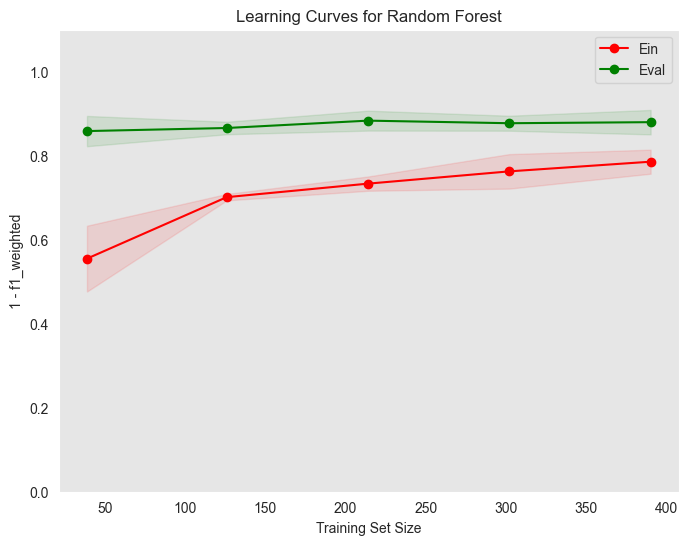

In [152]:
# use random forest to predict
from sklearn.ensemble import RandomForestClassifier

# create random forest classifier
rf = RandomForestClassifier(n_estimators=10, max_depth=3)

# fit the model
rf.fit(X_train, y_train)


# cross validation
# -------------

cv_results = cross_validate(rf, X, y, cv=NUM_FOLDS, scoring=[
                            'f1_macro', 'accuracy', 'f1_micro'])

print(f'Results for cross validation with {NUM_FOLDS} folds:')
print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())

print('-' * 50)
# test and train
# -------------

# fit the model
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)

# evaluate
acc = accuracy_score(y_test, y_pred)

print(f'Results for train and test with {TEST_RATIO} as a test ratio')

print('accuracy: ', acc)

print('-' * 50)
# Bias-variance Analysis
# -------------

mse, bias, var = getBiasVariance(
    rf, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

print("bias: ", bias)
print("var: ", var)

print('-' * 50)
# Learning Curve Analysis
# -------------
plt = getLearningCurvePlot(estimator=rf, X=X, y=y,
                           cv=NUM_FOLDS, modelname='Random Forest')
plt.show()




/home/mostafa/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Results for cross validation with 5 folds:
accuracy:  0.22122869766463285
f1_macro:  0.11231254907880109
f1_micro:  0.22122869766463285
--------------------------------------------------
Results for train and test with 0.2 as a test ratio
accuracy:  0.2755102040816326
--------------------------------------------------
bias:  5.112715306122449
var:  1.7483051020408167
--------------------------------------------------


/home/mostafa/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


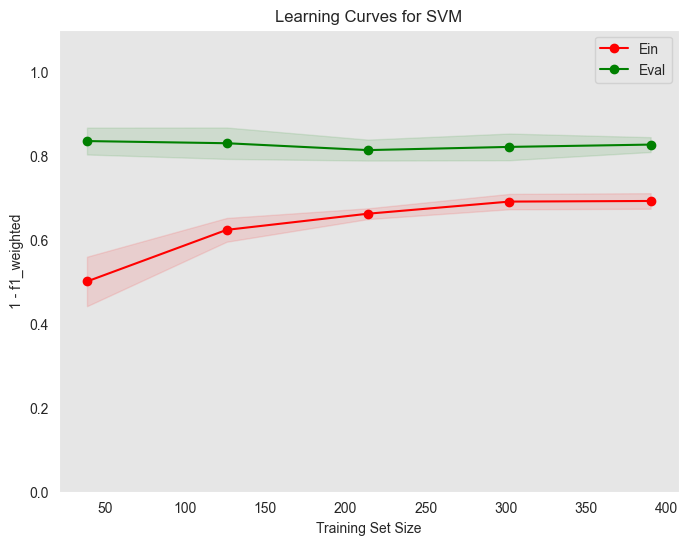

In [153]:
# use SVM to predict
from sklearn.svm import SVC

# create an SVM classifier
svm = SVC(gamma='auto', kernel='linear', C=10.0, random_state=0)

# fit the model
svm.fit(X_train, y_train)


# cross validation
# -------------
cv_results = cross_validate(svm, X, y, cv=NUM_FOLDS, scoring=[
                            'f1_macro', 'accuracy', 'f1_micro'])

print(f'Results for cross validation with {NUM_FOLDS} folds:')
print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())

print('-' * 50)
# test and train
# -------------
# fit the model
svm.fit(X_train, y_train)

# predict
y_pred = svm.predict(X_test)

# evaluate
acc = accuracy_score(y_test, y_pred)

print(f'Results for train and test with {TEST_RATIO} as a test ratio')

print('accuracy: ', acc)

print('-' * 50)
# Bias-variance Analysis
# -------------

mse, bias, var = getBiasVariance(
    svm, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

print("bias: ", bias)
print("var: ", var)

print('-' * 50)
# Learning Curve Analysis
# -------------
plt = getLearningCurvePlot(estimator=svm, X=X, y=y,
                           cv=NUM_FOLDS, modelname='SVM')
plt.show()



<div style="border-width:1; border-radius: 15px; border-style: solid; border-color: rgb(10, 10, 10); background-color: #316B83; text-align: center;font: 14pt 'Candara';font-weight:bold;"><h1> Interpreting Results</h1></div>


### Based on the analysis of our previous models, several key observations can be made:

### 1. Performance improvement: Our models have demonstrated superior performance compared to the dummy model in terms of both f1-score and accuracy. This signifies that the chosen features, namely "university, and faculty" significantly influence the company size that individuals are likely to join after completing their graduation. The results suggest a real and meaningful relationship between the current university and faculty attended and subsequent career outcomes.

### 2. Learning curve analysis: Upon analyzing the learning curves, it becomes evident that our model is exhibiting signs of underfitting. Despite the complexity of our models-concluded from the bias-variance analysis-, the underfitting issue is likely attributable to the limited size of our dataset. With a small amount of training data, the model struggles to capture the underlying patterns and complexities of the problem at hand. This limitation hampers the model's ability to generalize and perform optimally on unseen data.

## Addressing the underfitting concern requires careful consideration. Collecting more data could potentially help mitigate the issue and enable our models to better capture the intricacies of the relationship between the selected features and the company size.
